# Final Project Submission 3/5

 - Student name: Morgan Jones
 - Student pace: Full Time
 - Scheduled project review date/time: Mon, Jun 22, 2020, 4:00 PM - 4:45 PM France; Paris (GMT+2:00) [DST]
 - Instructor name: Abhineet Kulkarni
 - Blog post URL:
 ***

# Introduction

## Business Case

In continuing the hypothetical business case of GAN usage with the Netflix platform, we will explore the output of high quality images from StyleGAN2. It is with images of high definition that it will be possible to **create artificially generated casts indistinguishable from real actors for media streamed on the Netflix Platform to allow viewers customization of their media.** As demonstrated in the previous notebook, in order to produce high-quality images, we will need the performance of a GAN with deeper architecture, and access to a larger dataset of face images. To this end, we turn to StyleGAN2 and the FFHQ dataset.

## StyleGAN2 Architecture

To describe StyleGAN2 with any justice, one would need to mention some of the evolution that GANs have taken since their introduction to the deep learning community by Ian Goodfellow et al. in 2014 with the *Generative Adversarial Network Paper*. Since then architectures have involved convolutional layers like the DCGAN implemented in the last notebook, and taken various shapes in conditional GANs, Pix2Pix, and CycleGANs. BigGAN from Google's DeepMind team made much progress in using high levels of computational power and the 'truncation trick' to yield large improvements in image quality of GANs. 

Then in pursuit of high definition 1024x1024 images, Nvidia created ProGAN, named after its progressively growing nature to train layers of the generator and discriminator in a growing rate of resolution, adding stability to the training process until the output reaches the desired resolution. 

<img src='imgs/notebook_images/pro_gan.gif'>

Improving upon the ProGAN performance, Nvidia released a paper in 2018 introducing StyleGAN created by a team of Nvidia Engineers, those members being Tero Karras, Samuli Laine, Miika Aittala, Janne Hellsten, Jaakko Lehtinen, Timo Aila. StyleGAN is a method for generating high-resolution images with a similar architecture to ProGAN while adding a style transger methodology that alters the generator at each level of resolution by upscaling its resolution and feeding in a random input referred to as style noise. This random input is combined with an adaptive instance normalization (AdaIN) layer (https://arxiv.org/abs/1703.06868) that aligns the mean and variance of the content features with those of the style features. This combination informs the generator how to style the image at a particular resolution creating Style Mixing, which offers controllability by mixing styles at different scales. 

<img src='imgs/notebook_images/stylegan_architecture.png'>

<img src='imgs/notebook_images/style_gan2.jpg'>

The generator of StyleGANs analyze the image as a collection of 'styles', thus the name StyleGAN. Each style controls the effects at a certain scale. The effects of each style are highly localized in the generator so that for an architecture generating 1024x1024 images of faces: 

* Coarse Styles ($4^2-8^2$) effect pose, hair, and face shape
* Middle Styles ($16^2-32^2$) effect facial features, eyes
* Fine Styles ($64^2-1024^2$) effect color scheme

This demonstrated that by providing randomness at each step of upscaling during the generation of images, one can control the variations in images effectively. However the results produced have visible artifacts described as blob-shaped that resemble water droplets. These visual errors issue seem to occur at 64×64 resolution in all feature maps and get worse in higher resolution.

<img src='imgs/notebook_images/stylegan_artifacts.png'>

StyleGAN2 is an improvement of the quality of images produced, and resolves these visible artifacts. It had been found that the AdaIN layers lose some of the information during the input feed during normalization of the mean and variance of each feature map separately. This lost information appears in the form of an abnormal blob where the generator intentionally snuck in signal strength information past the instance normalization. Some further changes made in StyleGAN2 from StyleGAN were:

* Moving the noise module outside of the style module.
* Path Length Regularization
* The mean is not needed in normalizing the features

Another improvement that StyleGAN2 takes upon StyleGAN is in Weight Demodulation, which simplifies the StyleGAN design by replacing the instant normalization design.

<img src='imgs/notebook_images/stylegan2_architecture.png'>

With these improvements made on an already high performant architecture, StyleGAN2 demonstrates the ability of GANs to achieve the realism needed to offer users of Netflix high level customization on the platform. However, the architecture of the GAN is only part of the entire task. The dataset fed into the model is also a critical component to achieving the business case goal. We will explore the dataset used for this implementation of StyleGAN2 in the following section.

## Flickr-Faces-HQ (FFHQ) Dataset

As described by the NVlabs GitHub, the Flickr-Faces-HQ (FFHQ) dataset is a high-quality image dataset of human faces. It was first introduced in the StyleGAN paper *A Style-Based Generator Architecture for Generative Adversarial Networks* Tero Karras (NVIDIA), Samuli Laine (NVIDIA), Timo Aila (NVIDIA) http://stylegan.xyz/paper.

FFHQ is a relatively large dataset with around 70,000 1024x1024 resolution png images. The faces within the images contain variations in age, ethnicity, accessories like glasses and hats, as well as image backgrounds. The dataset was crawled from Flickr and is therefore a further proof of the usage of social media data with GANs. However because of its source, it also contains the bias within the website in terms of diversity. The images were cropped and aligned using dlib, and Amazon Mechanical Turk was used to remove noise from the images such as paintings, photos of photos, and statues.

The team made sure respect the privacy of Flickr users which may desire their privacy fully respected, as described by their following statement:

"When collecting the data, we were careful to only include photos that – to the best of our knowledge – were intended for free use and redistribution by their respective authors. That said, we are committed to protecting the privacy of individuals who do not wish their photos to be included."

<img src='imgs/notebook_images/ffhq_dataset.png'>

Having briefly introduced StyleGAN2 and the dataset used for this notebook, we can begin to implement the GAN in order to produce high rez images.

##### Attribution

The code for implementing StyleGAN2 in this notebook has been framed by Jeff Heaton's T81-558: Applications of Deep Neural Networks course part 7.3 of Washington University in St. Louis found here: https://github.com/jeffheaton/t81_558_deep_learning/blob/4ce39fc15d5300b0a83e3be5007ab47b8b8b0c99/t81_558_class_07_3_style_gan.ipynb and the exploration of the Ganspace portion by Derrick Shultz of BustBright in his StyleGAN2 repository found here: https://github.com/dvschultz/ai/blob/master/Ganspace_S2DD.ipynb.

# Implementing StyleGAN2

It would take several days to weeks to train StyleGAN2 from scratch on multiple GPU's. It is shared by the Nvidia team that to replicate performance shown in the paper, training with FFHQ on Tesla V100 GPUs, train times would be as follows:

<img src='imgs/notebook_images/training_times.png'>

We therefore will use a pre-trained model to produce high resolution images.

Even more so than the last notebook, a GPU is necessary as StyleGAN2 can only be run on them at the time of this work. As such it is best for our purposes to use Google CoLab to train our model, and set the runtime type to GPU. Also it is important to note that at this time, version TensorFlow 1.x is necessary as version 2.0 is not supported. The following cell when run in Google CoLab will connect us to Google Drive where the GAN will be housed and install TensorFlow version 1.x.

In [1]:
# Run this for Google CoLab (use TensorFlow 1.x)
%tensorflow_version 1.x
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

TensorFlow 1.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In order to import the pre-trained StyleGAN2 model, we can clone the Nvidia StyleGAN2 repository on GitHub with the following line.

In [2]:
# Clone the StyleGAN2 repo
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.


We then add the stylegan2 folder to python so that it can be imported and begin to generate images. On the GitHub repository the Nvidia team demonstrate how to do this with the following codeAdd the StyleGAN folder to Python so that you can import it.  The code below is based on code from NVidia and downloads the pre-trained network pickle file and references it by filename. From demonstrations, the stylegan2-ffhq-config-f.pkl seems to have the highest performance.

In [3]:
# Download and run pretrained StyleGAN2 model
!python /content/stylegan2/run_generator.py generate-images \
    --network=gdrive:networks/stylegan2-ffhq-config-f.pkl \
  --seeds=6600-6625 --truncation-psi=0.5

Local submit - run_dir: results/00000-generate-images
dnnlib: Running run_generator.generate_images() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Generating image for seed 6600 (0/26) ...
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 661

With that line we have produced 26 images based on the 1024 n-dimensional latent noise vector seed that it was generated from. These seed values are used to have a random number generator create the vector. 

In [4]:
!ls /content/results/00000-generate-images

_finished.txt  seed6604.png  seed6611.png  seed6618.png  seed6625.png
log.txt        seed6605.png  seed6612.png  seed6619.png  submit_config.pkl
run.txt        seed6606.png  seed6613.png  seed6620.png  submit_config.txt
seed6600.png   seed6607.png  seed6614.png  seed6621.png
seed6601.png   seed6608.png  seed6615.png  seed6622.png
seed6602.png   seed6609.png  seed6616.png  seed6623.png
seed6603.png   seed6610.png  seed6617.png  seed6624.png


We can then copy those images into our Google Drive so we can see the images have indeed been generated:

In [0]:
cp /content/results/00000-generate-images/* /content/drive/My\ Drive/projects/stylegan2

<img src='imgs/notebook_images/sg_seeds.png'>

To view the images, we can import OpenCV2 like we did in the previous notebooks. Due to the fact that we are using Google CoLab, we will use the module `cv2_imshow` from the `google.colab.patches` library.

In [0]:
# Import OpenCV2
import cv2
# Import cv2_imshow to view image
from google.colab.patches import cv2_imshow

Now we can view the image with `cv2.imread()` and `cv2.imshow()`.

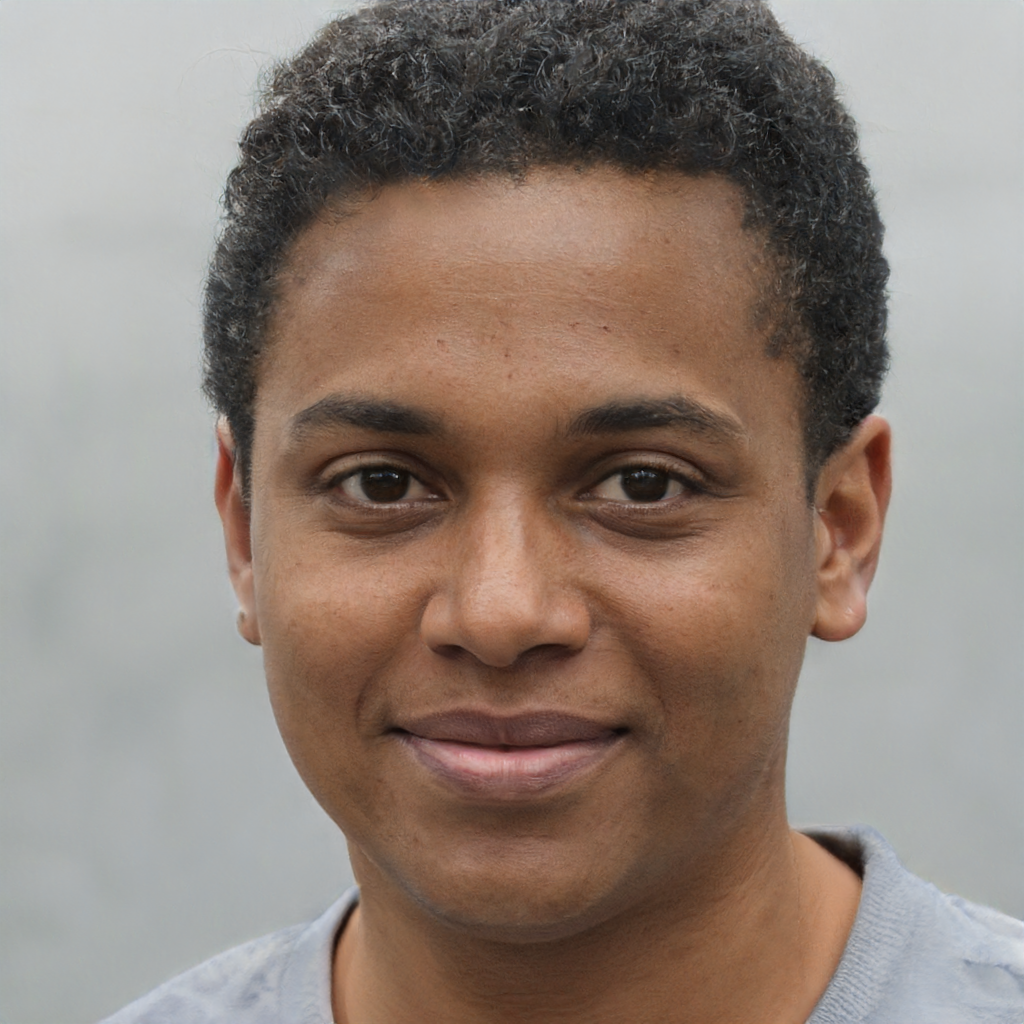

In [7]:
# Create an OpenCV2 object
img = cv2.imread('/content/drive/My Drive/projects/stylegan2/seed6600.png')
# View the image
cv2_imshow(img)

There we have our first 1024x1024 resolution generated image of a face with StyleGAN2!

In order to give an example of how the latent noise vector defines features within the output image, we can use style-mixing to create an interpolation between two different images with the following line:

In [8]:
# Download style-mixing-example from Nvidia script
!python /content/stylegan2/run_generator.py style-mixing-example \
    --network=gdrive:networks/stylegan2-ffhq-config-f.pkl \
  --row-seeds=85,100,75,458,1500 --col-seeds=55,821,1789,293 --truncation-psi=1.0

Local submit - run_dir: results/00001-style-mixing-example
dnnlib: Running run_generator.style_mixing_example() on localhost...
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating W vectors...
Generating images...
Generating style-mixed images...
Saving images...
Saving image grid...
dnnlib: Finished run_generator.style_mixing_example() in 53s.


In order to run the model from python and generate the hundreds of intermediary images needed to we can use some code made available by Nvidia. We will first import sys and dnnlib, in order to make a path to the stylegan2 folder, essentially creating a package from the previously downloaded files.

In [0]:
# Create a package from the previously downloaded files
import sys
sys.path.insert(0, "/content/stylegan2")
# Import StyleGAN2
import dnnlib

We will then rewrite functions created by Nvidia to allow the model to create the images that are results of the seed change between 2 images.

* `expand_seed`: Allows the truncated seed numbers to be expanded into the full 1024 dimensional vector.
* `generate_images`: Passes in the Generator and the  latent vector and truncated psi to create noise values that effects the noise of the images, and fixes them to a single value. We loop over the seeds generate them to be fed into the GAN.

In [0]:
# Copyright (c) 2019, NVIDIA Corporation. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://nvlabs.github.io/stylegan2/license.html

import argparse
import numpy as np
import PIL.Image
import dnnlib.tflib as tflib
import re
import os

import pretrained_networks

# Allows the truncated seed numbers to be expanded into the full 1024 dimensional vector.
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

def generate_images(Gs, seeds, truncation_psi):
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d/%d ...' % (seed_idx, len(seeds)))
        rnd = np.random.RandomState(seed=1)
        tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(seed, None, **Gs_kwargs) # [minibatch, height, width, channel]
        path = f"/content/tmp/image-{seed_idx}.png"
        PIL.Image.fromarray(images[0], 'RGB').save(path)

Here we specify the two seeds that we wish to interpolate between, extract the latent vector and slowly convolve until we reach the final seed value. We load the GAN bu referencing the pre-trained pickle file and extract two seeds from the model.

In [11]:
# Instantiate the GAN 
sc = dnnlib.SubmitConfig()
# Define the number of GPU's 
sc.num_gpus = 1
# Define where the target is for the images
sc.submit_target = dnnlib.SubmitTarget.LOCAL
# State that we do not want the images copied
sc.local.do_not_copy_source_files = True
# Define directory where the model is housed
sc.run_dir_root = "/content/drive/My Drive/projects/stylegan2"
# Define where the generated images are stored
sc.run_desc = 'generate-images'
# Define the pretrained model
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'

print('Loading networks from "%s"...' % network_pkl)
# Define the Generator, Discriminator, and GAN model
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
# Define the size of the latent vector fed to the generator
vector_size = Gs.input_shape[1:][0]
# Define the seeds fed to the generator
vec = expand_seed( [6615,6600], vector_size) # Morph between these two seeds
# Generate_images(Gs, seeds,truncation_psi=0.5)
print(vec[0].shape)

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
(1, 512)


We can define how many steps there will be in our interpolation. In this case we will choose 300 steps, or 300 unique images of the space between the beginning seed and the final seed. We then iterate through the space between the two seeds and incrementally add the photo found at each 1/300 step to the temporary file found at the temp_path object with the `generate_images()` method.

In [12]:
# Number of images created
STEPS = 300
diff = vec[1] - vec[0]
# Define the difference between the beginning and final seed
step = diff / STEPS
# Step amount needed to move through the latent space between beginning and final seed
current = vec[0].copy()

vec2 = []
for i in range(STEPS):
  vec2.append(current)
  current = current + step

temp_path = "/content/tmp"

# Create a temporary directory to hold video frames
try:  
  os.mkdir(temp_path)
except OSError:  
  print("Temp dir already exists.")

generate_images(Gs, vec2,truncation_psi=0.5)

Generating image for seed 0/300 ...
Generating image for seed 1/300 ...
Generating image for seed 2/300 ...
Generating image for seed 3/300 ...
Generating image for seed 4/300 ...
Generating image for seed 5/300 ...
Generating image for seed 6/300 ...
Generating image for seed 7/300 ...
Generating image for seed 8/300 ...
Generating image for seed 9/300 ...
Generating image for seed 10/300 ...
Generating image for seed 11/300 ...
Generating image for seed 12/300 ...
Generating image for seed 13/300 ...
Generating image for seed 14/300 ...
Generating image for seed 15/300 ...
Generating image for seed 16/300 ...
Generating image for seed 17/300 ...
Generating image for seed 18/300 ...
Generating image for seed 19/300 ...
Generating image for seed 20/300 ...
Generating image for seed 21/300 ...
Generating image for seed 22/300 ...
Generating image for seed 23/300 ...
Generating image for seed 24/300 ...
Generating image for seed 25/300 ...
Generating image for seed 26/300 ...
Generating 

The following is a gif created from images compiled in the vec2 list with ffmpeg. FFMPEG stands for Fast Forward MPEG and is a free and open-source software suite of libraries and programs for handling video, audio, and other multimedia files and streams. Finally we convert and save those images to a .gif with the cells below.

In [13]:
# Use FFMPEG to create a gif of the images in temp_path
! ffmpeg -r 30 -i /content/tmp/image-%d.png -vcodec mpeg4 -y /content/gan_morph.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [0]:
# Download the newly created movie
files.download('/content/gan_morph.mp4')

<img src='imgs/notebook_images/morph_gif.gif'>

We have successfully generated high quality images of faces that resemble living people! Not only are these faces realistic, but we are able to explore the latent space that defines them. 

# Conclusion
***

In this notebook we were able to:
    
* Briefly describe the evolution of large GANs and the architecture of Nvidia's StyleGAN2, as well as the shape and source of the Flickr-Faces-HQ (FFHQ) dataset.
* Implement a pretrained StyleGAN2 cloned from the Nvidia StyleGAN2 github repository
* Generate over 300 1024x1024 resolution images of faces that are near indistinguishable from samples within the FFHQ training set.
* Create interpolation footage of the latent space between two seed images generated by StyleGAN2

This notebook contains arguably the most important component to the hypothetical business case for the Netflix streaming platform. With this work entire libraries of artificially generated casts can be produced to allow user's to choose the distribution of diversity in the media they watch. In the next notebook we will use First Order Motion Models to map these generated faces and animate them in accordance to the source video, such as that found on the Netflix platform.